In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

import Bio.SeqIO

In [2]:
# Loading values
d1 = pd.read_csv("../../data/stability/raw/RNA_raw_counts_05_28_20.tsv", sep="\t", header=0)

# Loading sequences
sequence_fasta = list(Bio.SeqIO.parse("../../data/stability/raw/library_order_05_06_19_selected_sequences.fa", "fasta"))
assert len(set(rec.name for rec in sequence_fasta)) == len(sequence_fasta), "Duplicates found"
seqs = {rec.name: rec.seq.__str__().upper() for rec in sequence_fasta}

# Mapping
d1.insert(0, "seq", d1["seq_id"].map(seqs))

In [3]:
import re

meta_cols = {"seq", "seq_id"}

def rename_col_names(col_name):
    if col_name in meta_cols:
        return ("meta", col_name)
    replicate, bin_ = re.match(r"(\d+)_(\d+)", col_name).group(1, 2)
    return "data", ("RNA", replicate, bin_)

In [ ]:
d1.columns = pd.MultiIndex.from_tuples([rename_col_names(i) for i in d1.columns])
d1_meta = d1["meta"].copy()
d1 = d1["data"].copy()
d1.columns = pd.MultiIndex.from_tuples(d1.columns, names=["exp_type", "replicate", "bin"])
d1.sort_index(axis=1, inplace=True)
d1.index = d1_meta["seq"]
d1 = d1.astype("Int32")
d1.head(10).reset_index()

<Axes: ylabel='Frequency'>

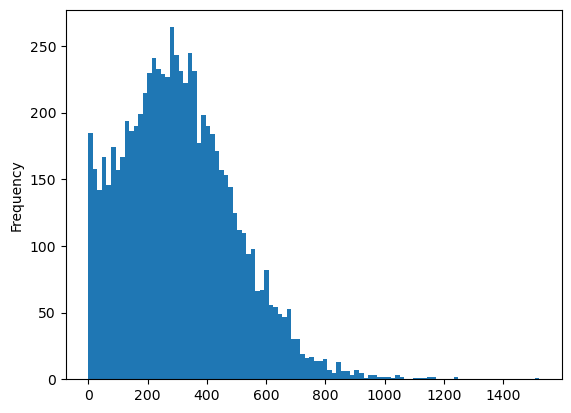

In [6]:
d1.mean(axis=1).plot.hist(bins=100)

In [7]:
def fit_bayesian_model(library):
    basic_model = pm.Model()

    with basic_model:
        # Priors for unknown model parameters

        # Mixture weights
        wd = pm.Dirichlet("wd", a=np.ones(2))
        psi = pm.Uniform("psi", lower=0.0, upper=1.0)

        # ZINB-1
        p1 = pm.Beta("p1", alpha=3, beta=1)
        n1 = pm.Uniform("n1", lower=0.0, upper=10.0)

        # ZINB-2
        p2 = pm.Beta("p2", alpha=1, beta=3)
        n2 = pm.Uniform("n2", lower=0.0, upper=10.0)

        # Mixture
        components = [
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi, p=p1, n=n1),
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi, p=p2, n=n2),
        ]

        # Likelihood (sampling distribution) of observations
        likelihood = pm.Mixture('mixture', w=wd, comp_dists=components, observed=lib)

        # draw 1000 posterior samples
        idata = pm.find_MAP()
    return idata

In [ ]:
fit_results = list()
for col_id in tqdm(list(d1)):
    exp_type, replicate_id, bin_id = col_id
    result = {"exp_type": exp_type,
              "replicate": replicate_id,
              "bin": bin_id}
    lib = d1[col_id].values
    idata = fit_bayesian_model(lib)

    fit_params = {
        "wd1": idata["wd"][0].item(),
        "wd2": idata["wd"][1].item(),
        "psi": idata["psi"].item(),
        "p1": idata["p1"].item(),
        "n1": idata["n1"].item(),
        "p2": idata["p2"].item(),
        "n2": idata["n2"].item(),
    }
    result |= fit_params
    fit_results.append(result)

In [10]:
pd.DataFrame(fit_results).to_csv("fit_results_stability_RNA.csv", index=False)

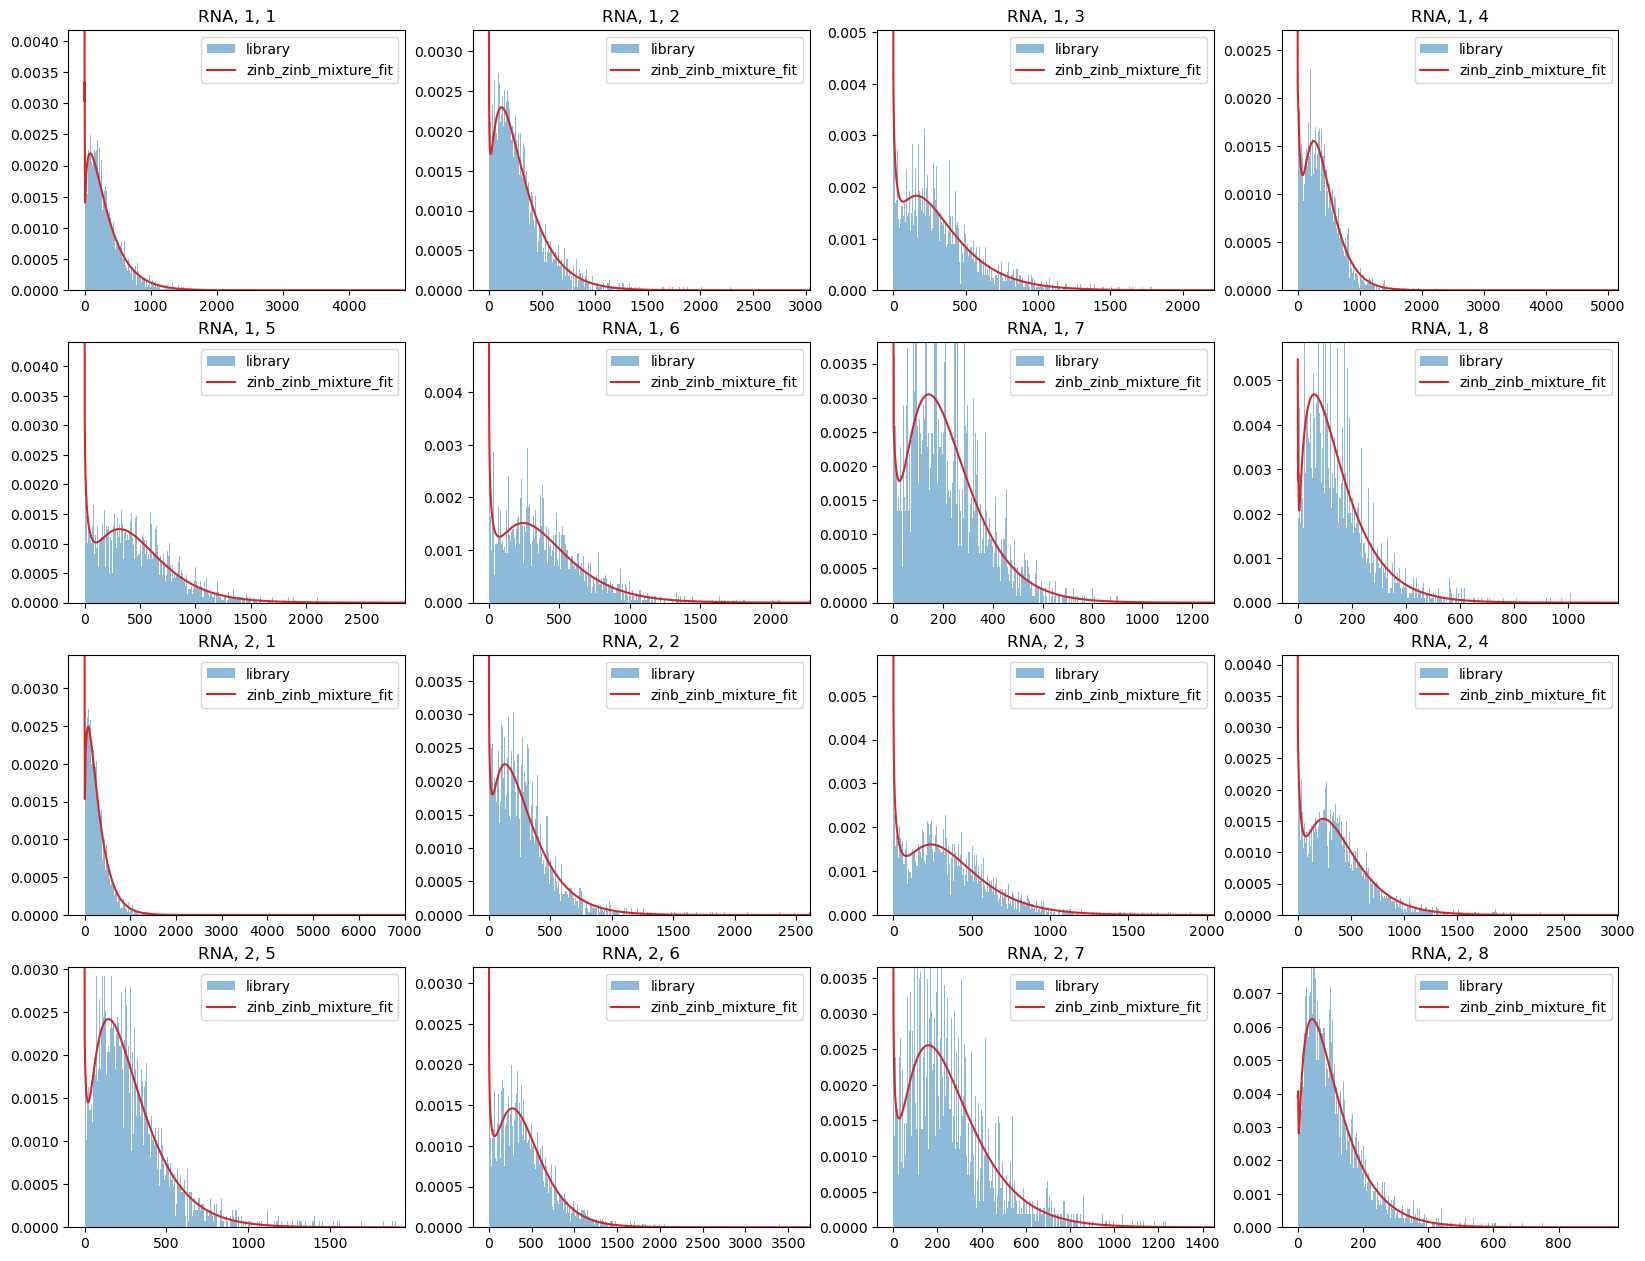

In [11]:
plt.figure(figsize=(20, 48))
for i, (col_id, fit_res) in enumerate(zip(list(d1), fit_results)):
    wd_est = np.asarray([fit_res["wd1"], fit_res["wd2"]])
    psi_est = fit_res["psi"]
    p1_est = fit_res["p1"]
    p2_est = fit_res["p2"]
    n1_est = fit_res["n1"]
    n2_est = fit_res["n2"]

    mixture_dist = pm.Mixture.dist(
        w=wd_est,
        comp_dists=[
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi_est, p=p1_est, n=n1_est),
            pm.ZeroInflatedNegativeBinomial.dist(psi=psi_est, p=p2_est, n=n2_est),
        ]
    )

    lib = d1[col_id]
    xlim_empiric = lib.max()

    logcdf = pm.logcdf(mixture_dist, np.arange(0, xlim_empiric)).eval()
    cdf = np.exp(logcdf)
    pdf = np.concatenate([cdf[:1], cdf[1:] - cdf[:-1]])
    ylim_empiric = pdf[1:].max() * 1.25

    plt.subplot(12, 4, i + 1)
    plt.hist(lib, bins=1000, density=True, alpha=0.5, label="library")
    plt.plot(pdf, color="C3", label="zinb_zinb_mixture_fit")
    plt.legend(loc="upper right")
    plt.xlim(-xlim_empiric // 20, xlim_empiric)
    plt.ylim(0, ylim_empiric)
    plt.title(", ".join(col_id))
plt.savefig("fit_chart_stability_RNA.svg")
plt.show()